# Capstone Project: Milestone Report
### Vikash Patel

As a large grocery and goods retailer, it is always in your best interests to hold your inventory at optimal levels. Store managers look to reduce spoilage risk of over-stocking perishable goods, and also hope to avoid being out-of-stock of goods that are heavily demanded. These scenarios are stressed during times of severe weather, such as heavy rainfall or snowfall. Are the effects of weather large enough to change buying patterns of potentially weather sensitive goods (like milk, bread, umbrellas) at stores? Or are there other factors that are more influential to consumers when going to the store? In this case study, I will be testing to see if there is a relationship between sales of weather sensitive goods and weather, and will also be forecasting future sales using a predictive regression model. The aim of this case study is to help give store managers a better approach on handling inventory management during times of severe weather.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

raw_weather = pd.read_csv('data/weather.csv')
sales_train = pd.read_csv('data/train.csv')
key = pd.read_csv('data/key.csv')

In [2]:
raw_weather.head(3)

station_nbr        date tmax tmin tavg depart dewpoint wetbulb heat cool  \
0            1  2012-01-01   52   31   42      M       36      40   23    0   
1            2  2012-01-01   48   33   41     16       37      39   24    0   
2            3  2012-01-01   55   34   45      9       24      36   20    0   

  sunrise sunset     codesum snowfall preciptotal stnpressure sealevel  \
0       -      -  RA FZFG BR        M        0.05       29.78    29.92   
1    0716   1626          RA      0.0        0.07       28.82    29.91   
2    0735   1720                  0.0        0.00       29.77    30.47   

  resultspeed resultdir avgspeed  
0         3.6        20      4.6  
1         9.1        23     11.3  
2         9.9        31     10.0

In [3]:
sales_train.head(3)

date  store_nbr  item_nbr  units
0  2012-01-01          1         1      0
1  2012-01-01          1         2      0
2  2012-01-01          1         3      0

In [4]:
key.head(3)

store_nbr  station_nbr
0          1            1
1          2           14
2          3            7

The datasets I am working with are very basic in detail. There is no key as to what item each item number corresponds to. Also, a disclaimer in the sales dataset noted that item numbers are not consistent for each store, meaning item 1 in store 1 may not be the same as item 1 in store 2. This prevents me from looking at overall item trends across different stores in relation to weather. I will have to conduct this analysis on a store by store basis. The key dataset is what describes the relationship between certain stores and their respective weather stations, and will be necessary for joining the sales and weather data together. Multiple stores will point to the same weather station. From the weather dataset, we will be utilizing the 'tavg' (average daily temperature) and 'preciptotal' (daily precipitation total) columns, as both are primary indicators of the weather. Conditions with recorded precipitation and average temperatures below 32 degrees F will be indicative of winter weather (freezing rain, sleet, snow).

In [5]:
weather_df = raw_weather[['date','station_nbr','tavg','preciptotal']]
replacements = {'tavg' : {r'M' : np.nan},
                'preciptotal' : {r'T' : 0.00, r'M' : np.nan}}
clean_weather = weather_df.replace(replacements, regex=True)
clean_weather.dropna(inplace=True)
clean_weather['tavg'] = clean_weather['tavg'].apply(pd.to_numeric)
clean_weather['preciptotal'] = clean_weather['preciptotal'].apply(pd.to_numeric)
clean_weather.head(3)

date  station_nbr  tavg  preciptotal
0  2012-01-01            1    42         0.05
1  2012-01-01            2    41         0.07
2  2012-01-01            3    45         0.00

The cleaning transformations above replaced trace precipitation values with zero. In the overall sense of the precipitation data, trace amounts are not significant to the rest of the data. Also, rows with missing data are completely removed. This action was taken because there were many stations that only included a few months worth of data, and would be hard justify using any missing value replacement function. One of the purposes of this case study is to see the relationship between sales and weather, so using inaccurate weather data would potentially skew our results, and lead to an flawed conclusions. After the missing values are removed, the numeric columns are converted to numeric datatypes, ensuring that the data can be plotted.

/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


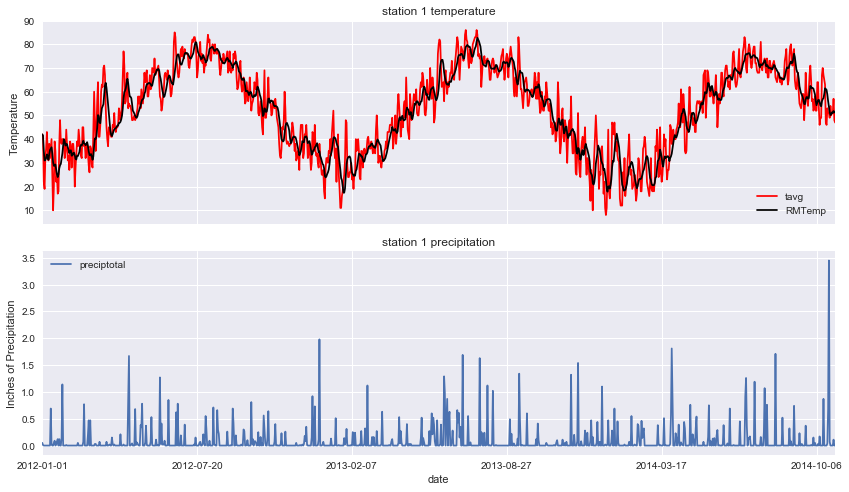

In [6]:
s1 = clean_weather.loc[weather_df.station_nbr == 1]
s1.set_index('date', inplace=True)
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(12,7))
s1['RMTemp'] = s1['tavg'].rolling(7, min_periods=1).mean()
s1.plot(y='tavg', ax=axes[0], title='station 1 temperature', color='red')
s1.plot(y='RMTemp', ax=axes[0], color = 'black')
axes[0].set_ylabel('Temperature')
s1.plot(y='preciptotal', ax=axes[1], title='station 1 precipitation')
axes[1].set_ylabel('Inches of Precipitation')
fig.tight_layout()
plt.show()

Using station 1 as an example for its temperature and precipitation plot, I can get an idea of what kind of weather each station is subject to. It has to be considered where these stations are generally located by their temperature patterns. This is important to think about since winter weather in colder climates is seen as standard and less likely to cause grocery store rushes, compared to winter weather in warmer climates. Also, deviations from normal temperatures of the season should also be considered. Sudden temperature changes, especially around winter time, may spur people to go to the store. Seen above, a rolling mean of the average temperature over 7 day periods was plotted on top of the average temperature plot to be able to help visualize sudden temperature changes.

In [10]:
clean_sales = pd.pivot_table(sales_train, values='units', index=['store_nbr', 'date'], columns=['item_nbr'])
clean_sales.head(5)

item_nbr              1    2    3    4    5    6    7    8    9    10  ...   \
store_nbr date                                                         ...    
1         2012-01-01    0    0    0    0    0    0    0    0   29    0 ...    
          2012-01-02    0    0    0    0    0    0    0    0   60    0 ...    
          2012-01-03    0    0    0    0    0    0    0    0   15    0 ...    
          2012-01-04    0    0    0    0    0    0    0    0   20    0 ...    
          2012-01-05    0    0    0    0    0    0    0    0   16    0 ...    

item_nbr              102  103  104  105  106  107  108  109  110  111  
store_nbr date                                                          
1         2012-01-01    0    0    0    0    0    0    0    0    0    0  
          2012-01-02    0    0    0    0    0    0    0    0    0    0  
          2012-01-03    0    0    0    0    0    0    0    0    0    0  
          2012-01-04    0    0    0    0    0    0    0    0    0    0  
          2012-01-05    0    0    0    0    0    0    0    0    0    0  

[5 rows x 111 columns]